In [ ]:
#    Copyright (C) 2026  DnMdr
#
#    This program is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.
#
#    This program is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.
#
#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
from pathlib import Path
from src.fukuzono import applica_fukuzono_qi
from src.letturadati import processa_dataset
from src.plot import plot_fukuzono

DATA_DIR = Path("data") # Directory dei dati
DATA_DIR.mkdir(parents=True, exist_ok=True)  # Crea la cartella dei dati se manca
OUTPUT_DIR = Path("output") # Directory di output
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)  # Crea la cartella di output se manca
FILE_CSV = Path(DATA_DIR, "dati_lanzada.csv") # Percorso del file CSV

COL_VELOCITA = "Lanzada Frana Fessurimetro F1 - Delta 1h [mm]"  # Cambia F1 con F2, F3, F4
COL_PIOGGIA = "LANZADA Campo Franscia Precipitazione - Dato Grezzo [mm]"    # Dato stazione ARPA Campo Franscia
COL_TEMP = "Lanzada Frana Temperatura roccia TR1 - Dato Grezzo [øC]"    # Dato studio geologico

### Definizione variabili Notebook
- **inizio_analisi**: Permette di decidere la data di inizio per l'analisi del dataset.
- **smoothing_technique**: Scegli 1 per Savitsky-Golay o 2 per media mobile
- **finestra_savgol**: Lunghezza della finestra filtro per il metodo savgol (sempre un numero dispari)
- **polinomio_savgol**: Ordine del polinomio utilizzato per il metodo savgol (2 o 3)
- **finestra_media_mobile**: Numero di campioni per la media mobile
- **v_stazionaria**: Velocità di riferimento (mm/h) per calcolo angolo tangente.
- **soglia_fit_alpha**: Inizia a calcolare la previsione Fukuzono solo sopra questa soglia dell'angolo tangente, i punti utilizzati vengono evidenziati in blu (minimo 80°)
- **coeff_correzione**: Coefficiente statistico di correzione (Qi et al., 2023) compreso tra 0.30 e 0.55 (Il metodo Fukuzono classico corrisponde a C=1)

In [2]:
from src.config import parametri

lanzada = parametri(
    inizio_analisi = "2025-11-08 00:00:00",
    encoding_csv = "latin1",
    smoothing_technique = 1,
    finestra_savgol = 25,
    polinomio_savgol = 2,
    finestra_media_mobile = 12,
    v_stazionaria = 0.02,
    soglia_fit_alpha = 80.0,
    coeff_correzione = 0.45,
    col_velocita = COL_VELOCITA,
    file_csv = FILE_CSV
)

In [3]:
# Funzione di caricamento file csv
df_main = processa_dataset(lanzada)

# Funzione di analisi tramite fukuzono e metodo proposto da Qi et al.
df_res, previsione, df_fit_used, filter_name = applica_fukuzono_qi(df_main, lanzada)

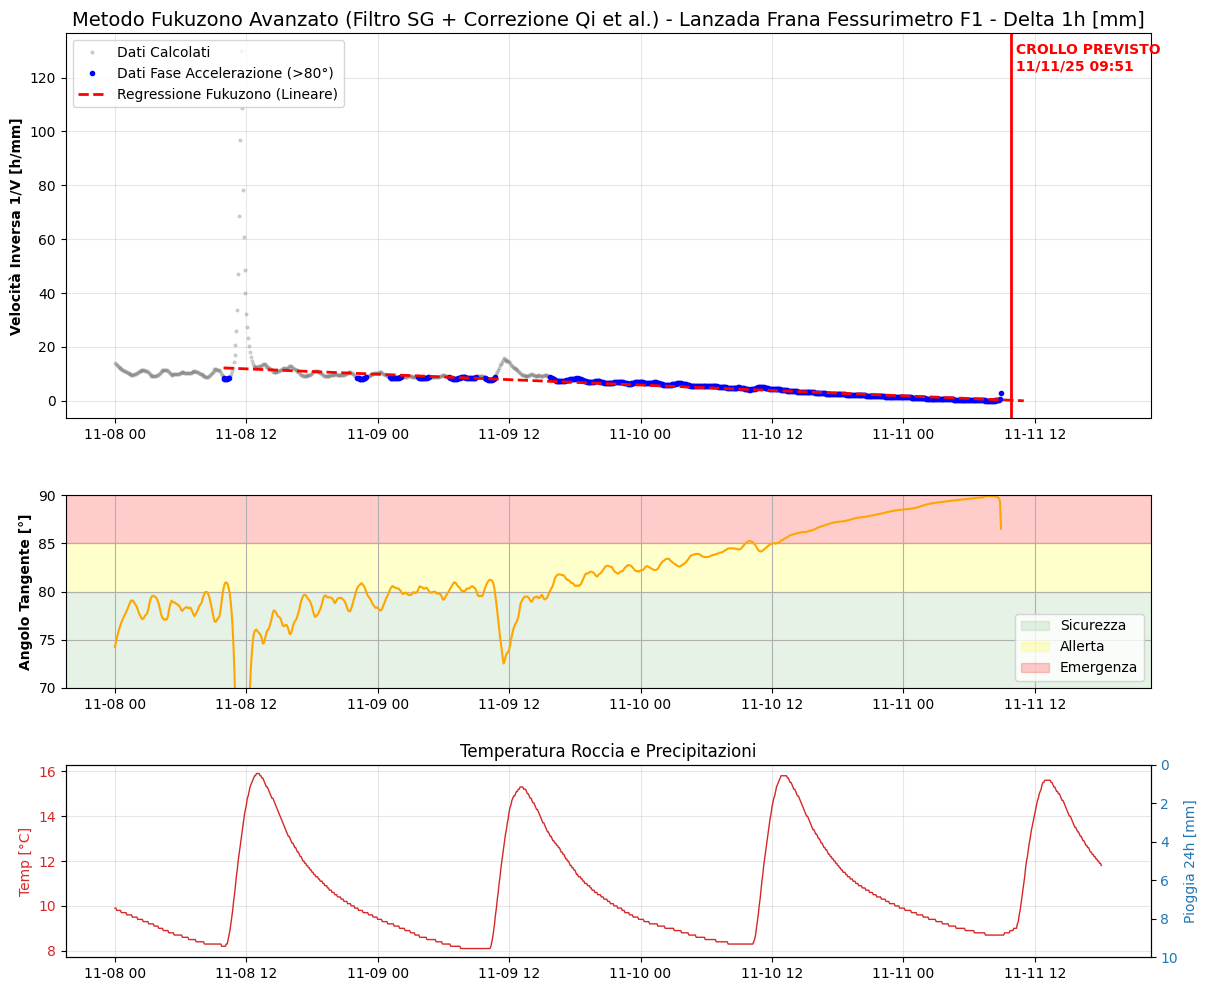

In [4]:
from src.config import configurazione_grafico

config_grafici = configurazione_grafico (
    filter_name = filter_name,
    figsize = (14, 12),
    col_velocita = COL_VELOCITA,
    col_temp = COL_TEMP,
    col_pioggia = COL_PIOGGIA,
    ylim_emergenza = (70,90)
)

# Funzione di plot
fig = plot_fukuzono(
    df_res, 
    df_main, 
    df_fit_used, 
    previsione, 
    config_grafici
)

fig.savefig(Path(OUTPUT_DIR, "grafico_fukuzono.png"), dpi=300, bbox_inches="tight")

In [5]:
# Stampa Report Testuale
from src.report import stampa_report_testuale
stampa_report_testuale(df_res, df_fit_used, previsione, lanzada)

--------------------------------------------------
REPORT ANALISI PREVISIONALE
--------------------------------------------------
Data Ultimo Dato Disponibile:11-11-2025 08:55:00
Previsione Lineare (Fukuzono):11-11-2025 11:00:05
Previsione Corretta (Fattore 0.45):11-11-2025 09:51:17
Differenza tra previsione e crollo effettivo:0 days 00:56:17
